In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sklearn
from sklearn.linear_model import LinearRegression

Question 1
Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank
r
. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics. [1 Marks]

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd
import torch, torchvision


# Load and preprocess the image
image_path = r"C:/Users/kapeb/Downloads/cat.png"
image = torchvision.io.read_image(image_path)
device = torch.device("cpu")
image.shape

torch.Size([4, 456, 499])

In [142]:
if image.shape[0] == 4:
    image_rgb = image[:3, :, :]  # Remove the alpha channel
else:
    image_rgb = image

image_rgb.shape

torch.Size([3, 456, 499])

crop2 = torchvision.transforms.functional.crop(img_scaled.cpu(),20 ,60, 300, 300)
crop.shape

In [143]:
img = torch.tensor(image_rgb, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([456, 499])


In [144]:
scaler_img = sklearn.preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))

# cales features to a specified range
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([456, 499])

In [145]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(),20 ,60, 300, 300)
crop.shape

torch.Size([300, 300])

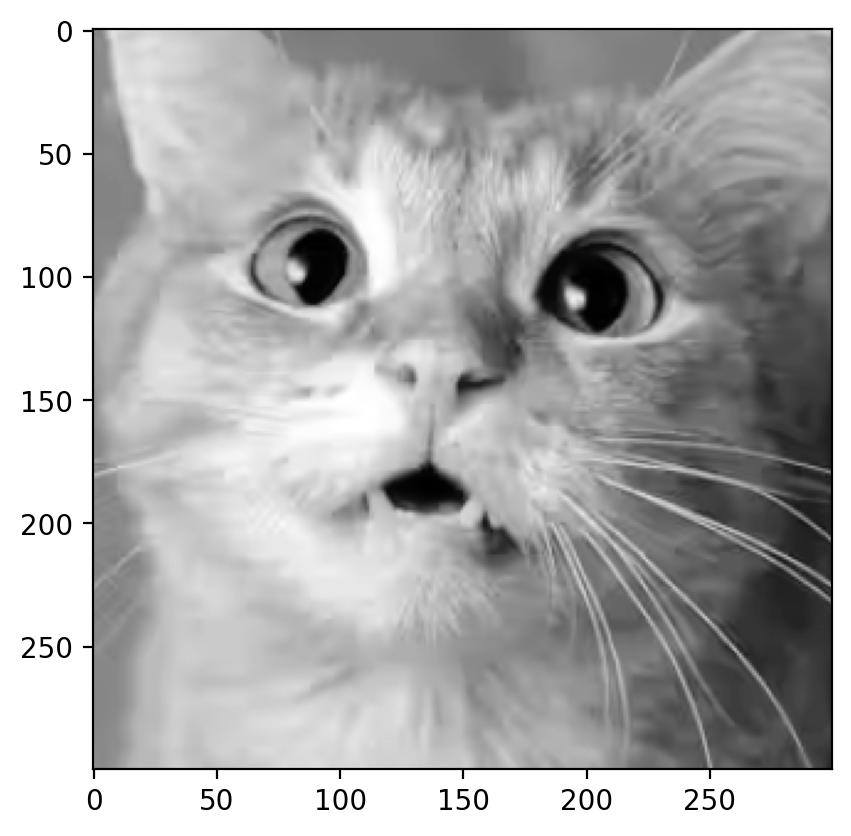

In [146]:
plt.imshow(crop, cmap='gray')

In [147]:
# Mask the image with NaN values
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask


masked_img = mask_image(crop, 0.3)
# masked_img[1].sum()

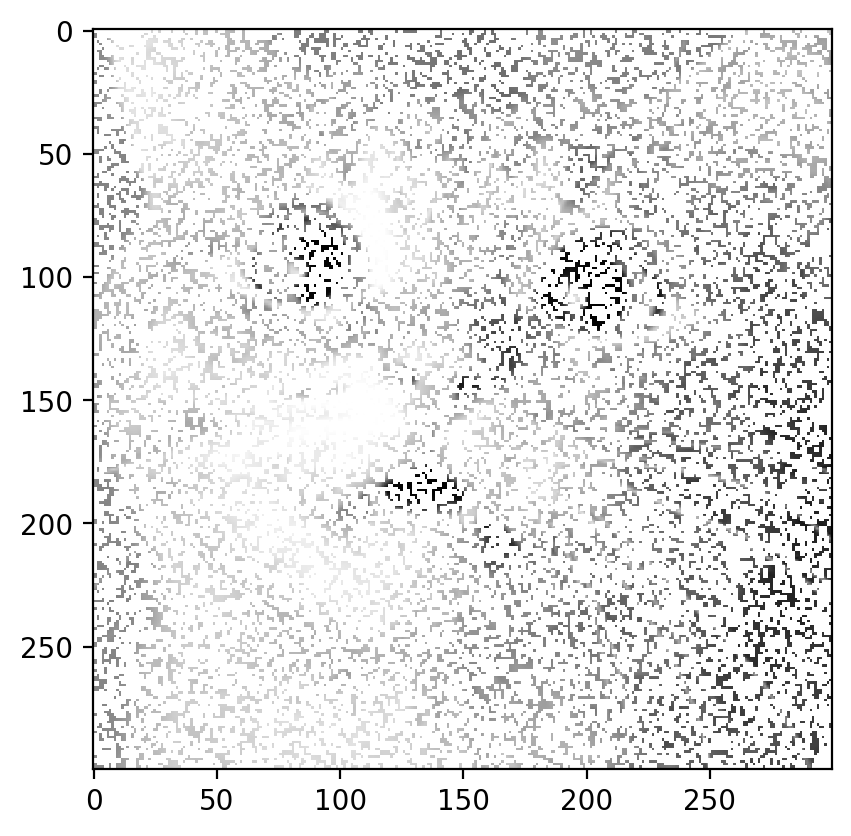

In [148]:
plt.imshow(masked_img[0], cmap='gray')

In [149]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss

In [150]:
W, H, loss = factorize(masked_img[0], 40, device=device)

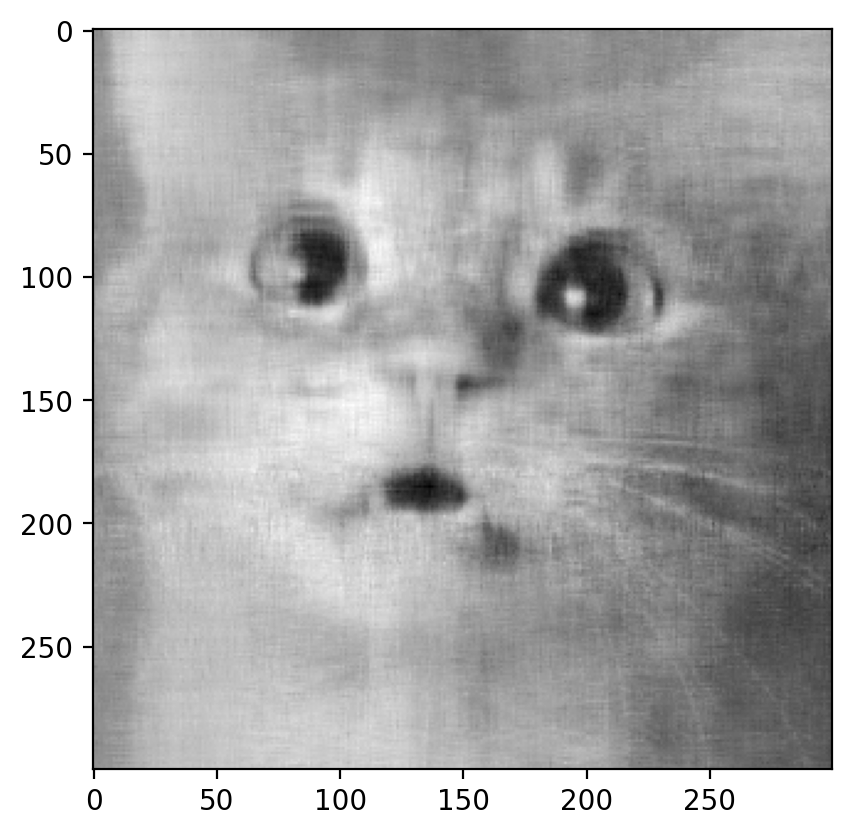

In [151]:
Reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
plt.imshow(Reconstructed_img, cmap='gray')

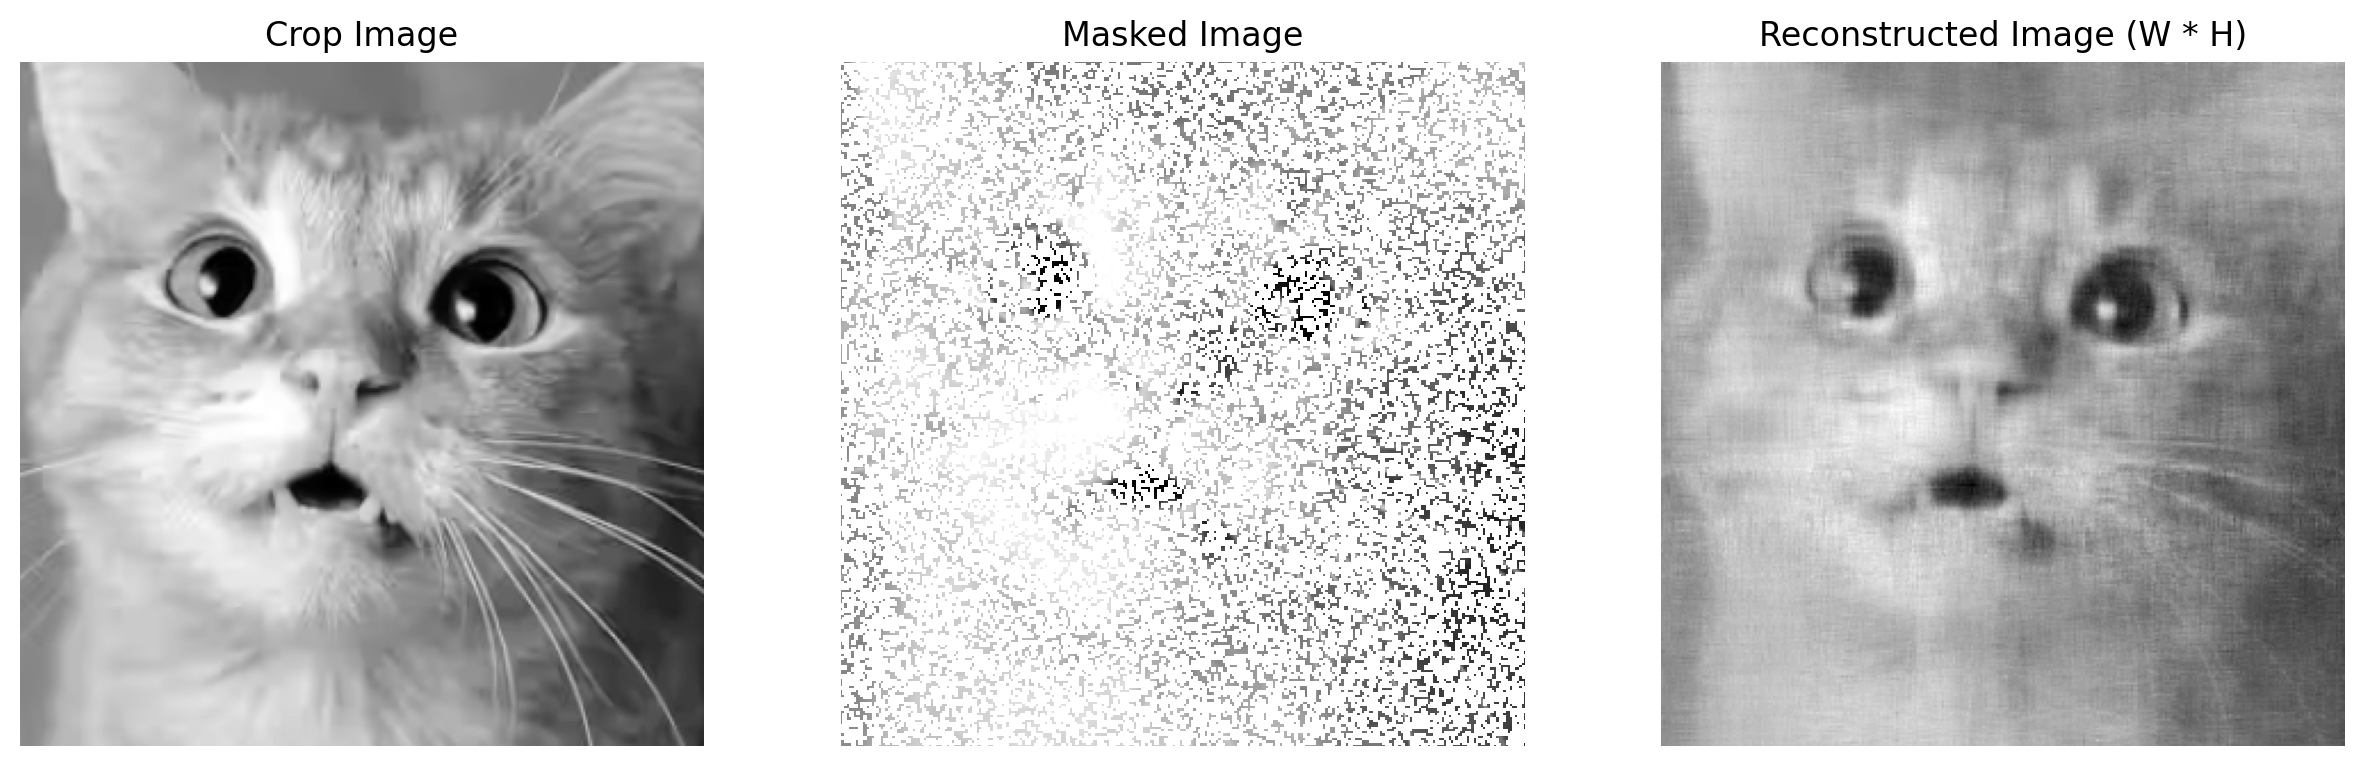

In [152]:
plt.figure(figsize=(15, 5))

# First image (crop)
plt.subplot(1, 3, 1)
plt.imshow(crop, cmap='gray')
plt.title('Crop Image')
plt.axis('off')

# Second image (masked_img[0])
plt.subplot(1, 3, 2)
plt.imshow(masked_img[0], cmap='gray')
plt.title('Masked Image')
plt.axis('off')

# Third image (torch.mm(W, H))
plt.subplot(1, 3, 3)
plt.imshow(Reconstructed_img , cmap='gray')
plt.title('Reconstructed Image (W * H)')
plt.axis('off')

# Display all three images
plt.show()


In [153]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

# Convert the original cropped image to numpy format
crop_numpy = crop.cpu().detach().numpy()

# Calculate MSE
mse_value = mean_squared_error(crop_numpy, Reconstructed_img)
rmse = np.sqrt(mse_value)
print(f"RMSE: {rmse}")

# Calculate PSNR
psnr_value = psnr(crop_numpy, Reconstructed_img, data_range=1)  # data_range=1 because the image is scaled between 0 and 1
print(f"PSNR: {psnr_value}")


RMSE: 0.04935613220695919
PSNR: 26.133177622523153


Question 2

Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.[3 Marks]

torch.Size([300, 300])
torch.Size([300, 300])


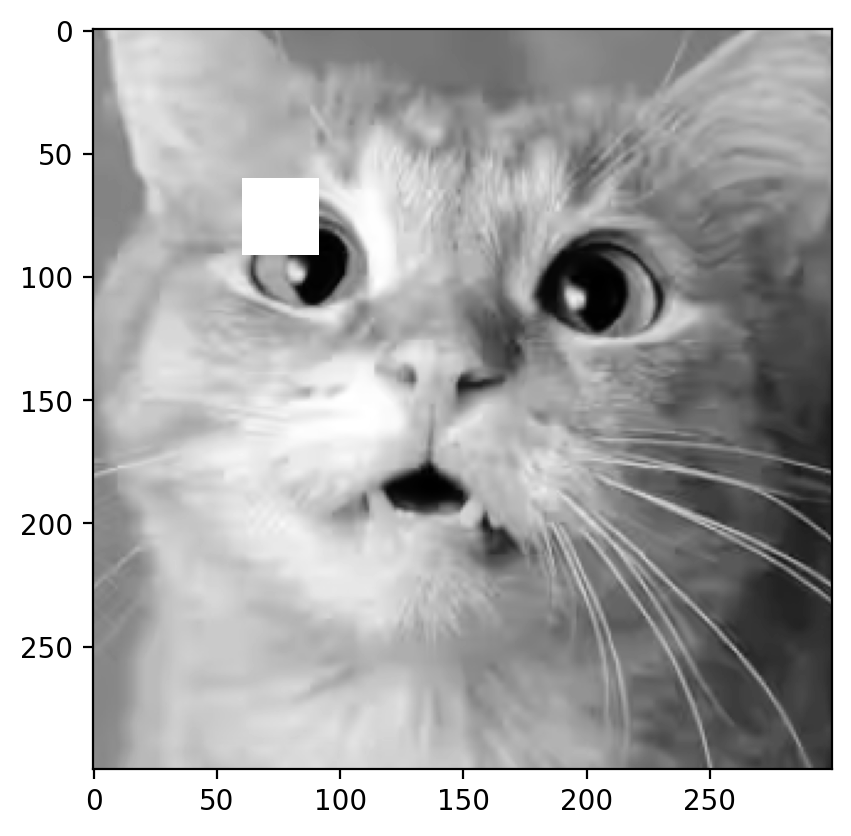

In [154]:
img_c = crop.clone()
print(img_c.shape)
img_c[61:91, 61:91] = float('nan')
plt.imshow(img_c, cmap= 'grey')
print(img_c.shape)

Apply Matrix Factorization

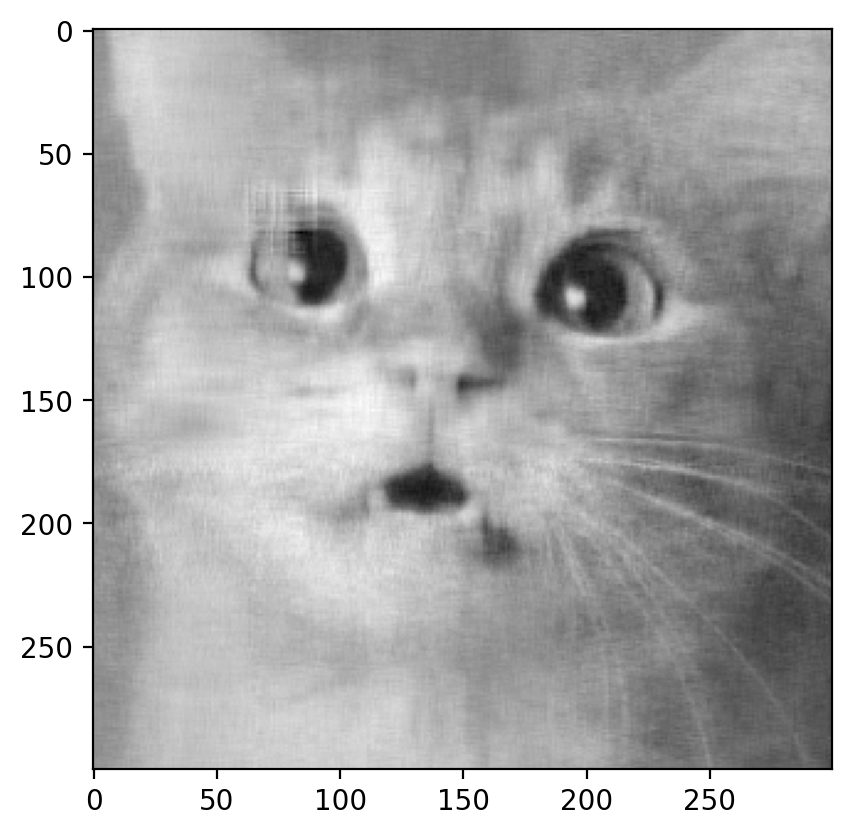

In [155]:
W, H, loss = factorize(img_c, 60, device=device)
Reconstructed_image = torch.mm(W, H).cpu().detach().numpy()
plt.imshow(Reconstructed_image , cmap='gray')

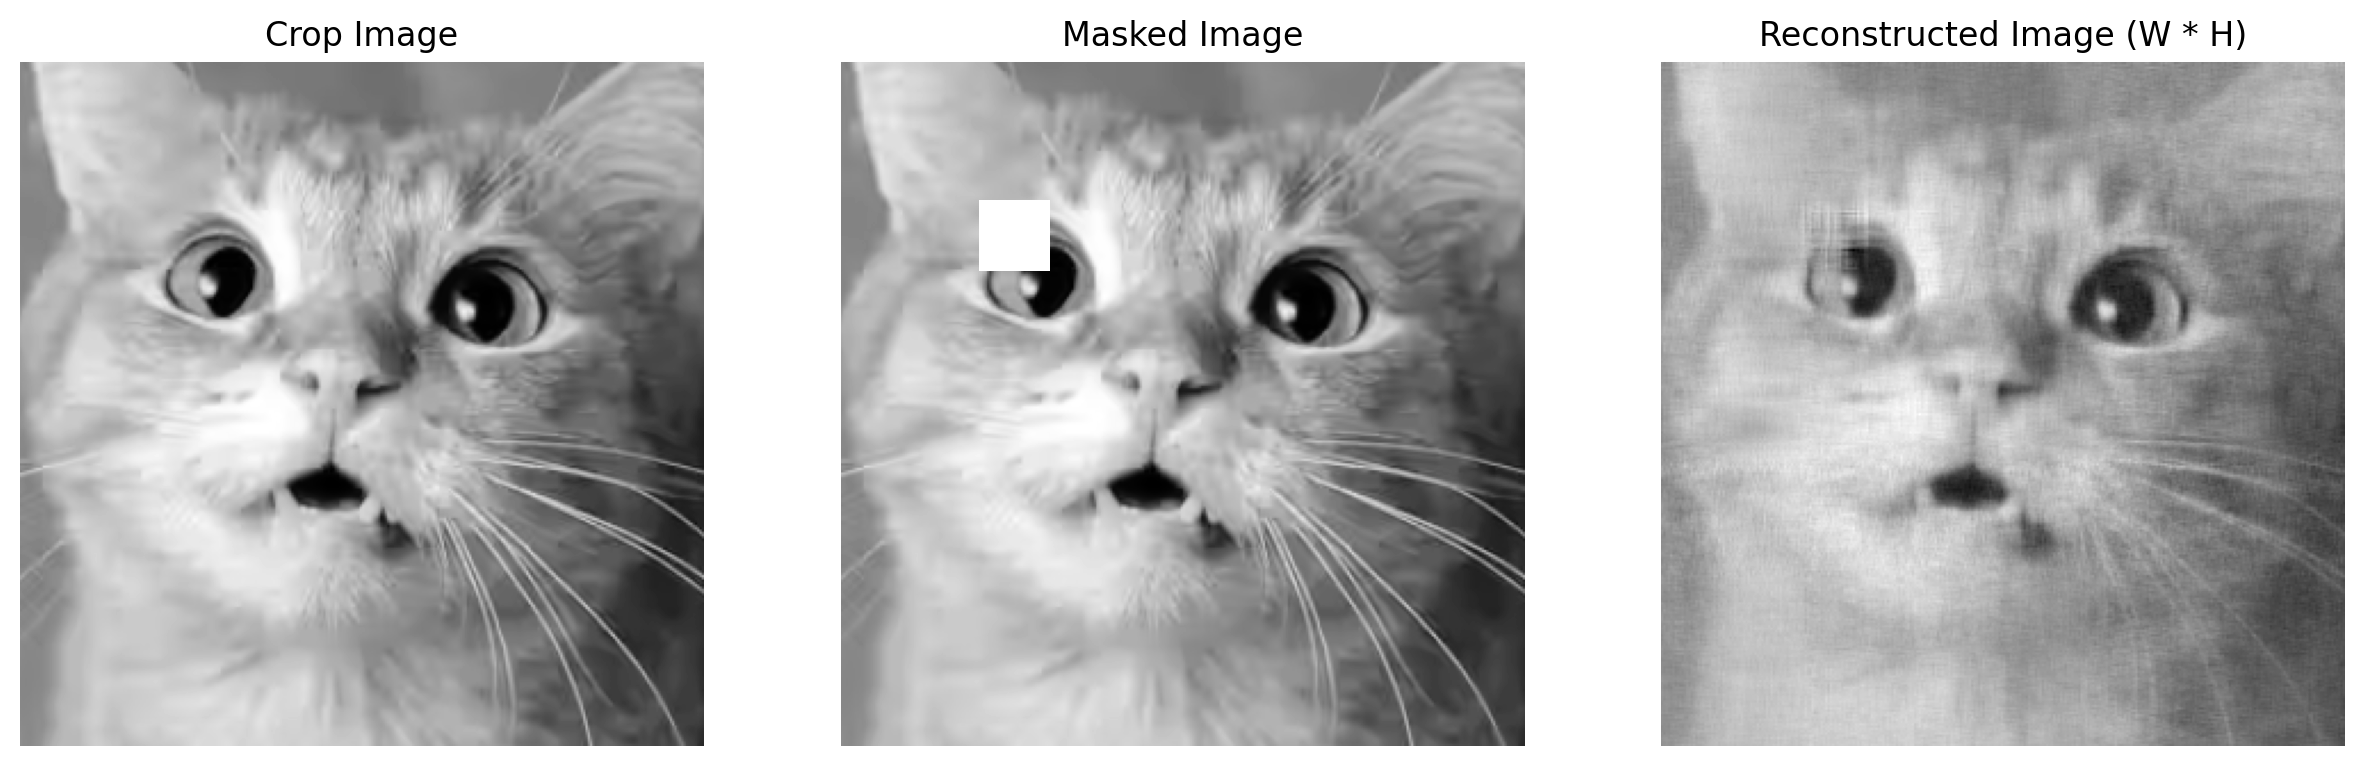

In [156]:
plt.figure(figsize=(15, 5))

# First image (crop)
plt.subplot(1, 3, 1)
plt.imshow(crop, cmap='gray')
plt.title('Crop Image')
plt.axis('off')

# Second image (img_c)
plt.subplot(1, 3, 2)
plt.imshow(img_c, cmap='gray')
plt.title('Masked Image')
plt.axis('off')

# Third image (torch.mm(W, H))
plt.subplot(1, 3, 3)
plt.imshow(Reconstructed_image, cmap='gray')
plt.title('Reconstructed Image (W * H)')
plt.axis('off')
plt.show()

In [157]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

# Convert the original cropped image to numpy format
crop_numpy = crop.cpu().detach().numpy()

# Calculate MSE
mse_value = mean_squared_error(crop_numpy, Reconstructed_image)
rmse = np.sqrt(mse_value)
print(f"RMSE: {rmse}")

# Calculate PSNR
psnr_value = psnr(crop_numpy, Reconstructed_image, data_range=1)  # data_range=1 because the image is scaled between 0 and 1
print(f"PSNR: {psnr_value}")


RMSE: 0.041459087934915644
PSNR: 27.647605125012106


#apply rff

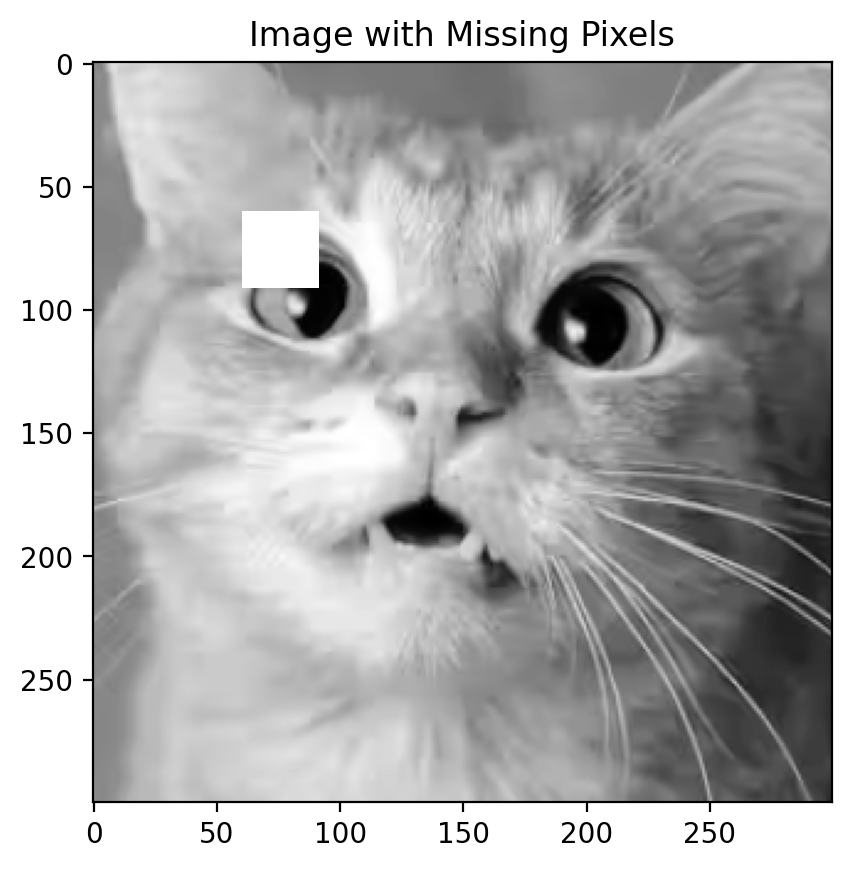

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Create a sample grayscale image (100x100) and insert NaN values in a 30x30 region
img_c = crop.clone()
img_c[61:91, 61:91] = float('nan')
plt.imshow(img_c, cmap='gray')
plt.title("Image with Missing Pixels")
plt.show()


In [159]:
 #Function to create coordinate map for the image
def create_coordinate_map(img):
    height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()
    Y = img.reshape(-1, 1).float()

    return X, Y

In [160]:
# Create coordinate map and target values
cat_X, cat_Y = create_coordinate_map(img_c)
cat_X, cat_Y = cat_X.to(device), cat_Y.to(device)

In [161]:
# Replace NaNs in cat_Y with zeros for training, but keep a valid mask
valid_mask = ~torch.isnan(cat_Y)
cat_Y[torch.isnan(cat_Y)] = 0  # Replace NaNs with zeros for training

In [162]:
# Scale the X coordinates (2D coordinates for the image)
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(cat_X.cpu())
cat_X_scaled = scaler_X.transform(cat_X.cpu())
cat_X_scaled = torch.tensor(cat_X_scaled).to(device).float()

# Function to create Random Fourier Features (RFF)
def create_rff_features(X, n_features, gamma):
    D = X.shape[1]
    W = torch.randn(D, n_features).to(device) * gamma
    b = 2 * np.pi * torch.rand(n_features).to(device)
    Z = torch.cos(torch.mm(X, W) + b)
    return Z

In [163]:
# Generate RFF features for the whole image
X_rff = create_rff_features(cat_X_scaled, 3750, 0.008)
print("RFF Feature Shape:", X_rff.shape)


RFF Feature Shape: torch.Size([90000, 3750])


In [164]:
# Define a linear model
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [165]:
# Initialize the linear model
net = LinearModel(X_rff.shape[1], 1)
net.to(device)


LinearModel(
  (linear): Linear(in_features=3750, out_features=1, bias=True)
)

In [166]:
# Training function
def train(net, lr, X, Y, epochs, device, verbose=True):
    net.to(device)
    X, Y = X.to(device), Y.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        # Compute loss only on valid pixels
        loss = criterion(outputs[valid_mask], Y[valid_mask])
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} loss: {loss.item():.6f}")

    print(f"Final loss after {epochs} epochs: {loss.item():.6f}")
    return loss.item()


In [167]:
# Train the model on the whole image
final_loss = train(net, 0.005, X_rff, cat_Y, 2500, device=device)

# Print final loss
print(f"Final loss after training: {final_loss:.6f}")

Epoch 0/2500 loss: 0.925828
Epoch 100/2500 loss: 0.044264
Epoch 200/2500 loss: 0.037852
Epoch 300/2500 loss: 0.035011
Epoch 400/2500 loss: 0.032585
Epoch 500/2500 loss: 0.030690
Epoch 600/2500 loss: 0.029313
Epoch 700/2500 loss: 0.028377
Epoch 800/2500 loss: 0.027779
Epoch 900/2500 loss: 0.027420
Epoch 1000/2500 loss: 0.027217
Epoch 1100/2500 loss: 0.027109
Epoch 1200/2500 loss: 0.027055
Epoch 1300/2500 loss: 0.027030
Epoch 1400/2500 loss: 0.027019
Epoch 1500/2500 loss: 0.027015
Epoch 1600/2500 loss: 0.027013
Epoch 1700/2500 loss: 0.027012
Epoch 1800/2500 loss: 0.027012
Epoch 1900/2500 loss: 0.735742
Epoch 2000/2500 loss: 0.027012
Epoch 2100/2500 loss: 0.027012
Epoch 2200/2500 loss: 0.027012
Epoch 2300/2500 loss: 0.323581
Epoch 2400/2500 loss: 0.027012
Final loss after 2500 epochs: 0.027012
Final loss after training: 0.027012


In [171]:
# Predict the entire image
predicted_img = net(X_rff).detach().cpu().numpy().reshape(300, 300)

# Create a copy of the original image to fill in the reconstructed region
reconstructed_img = img_c.clone().cpu()
reconstructed_img[61:91, 61:91] = torch.tensor(predicted_img[61:91, 61:91])

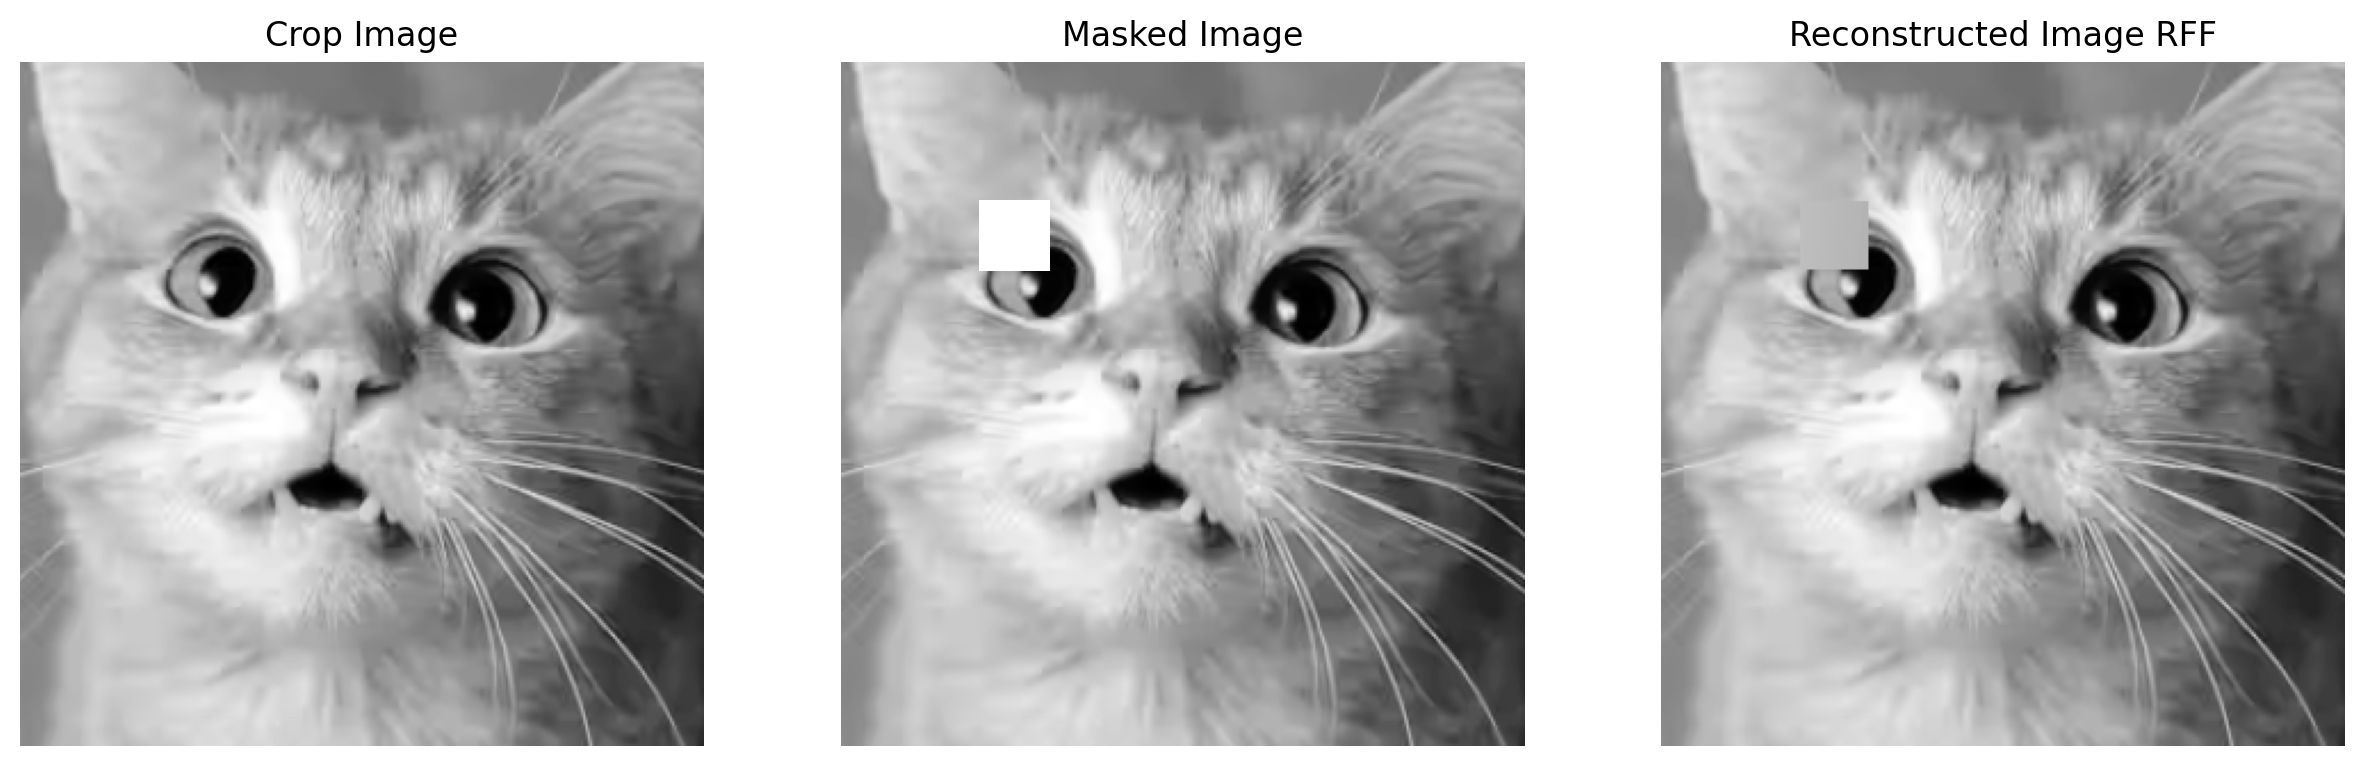

In [172]:
plt.figure(figsize=(15, 5))

# First image (crop)
plt.subplot(1, 3, 1)
plt.imshow(crop, cmap='gray')
plt.title('Crop Image')
plt.axis('off')

# Second image (img_c)
plt.subplot(1, 3, 2)
plt.imshow(img_c.cpu(), cmap='gray')
plt.title('Masked Image')
plt.axis('off')

# Third image (torch.mm(W, H))
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_img , cmap='gray')
plt.title('Reconstructed Image RFF')
plt.axis('off')
plt.show()


In [173]:

from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

# Convert the original cropped image to numpy format
crop_numpy = crop.cpu().detach().numpy()


# Calculate MSE
mse_value = mean_squared_error(crop_numpy, predicted_img)
rmse = np.sqrt(mse_value)
print(f"RMSE: {rmse}")

# Calculate PSNR
psnr_value = psnr(crop_numpy, predicted_img, data_range=1)  # Assuming the images are scaled between 0 and 1
print(f"PSNR: {psnr_value}")




RMSE: 0.16554316849991638
PSNR: 15.6217747330321


thus model1 onw with matrux factorization performed better